In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import subprocess
import polars as pl
import io
import itertools
import warnings

from brokenaxes import brokenaxes


from adjustText import adjust_text


# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference

In [4]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]
chrom_names = aut_chrom_names + ["chrX", "chrY"]

In [5]:
# Samples to do
sample_ids = [
    "PD50477f",
    # "PD50508bf", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD50519d",
    # "PD47269d", -- don't use, not there
    "PD50508f",
    # "PD50511e", -- don't use, likely mixture
    "PD50523b",
    # "PD48473b", -- don't use, not there
    "PD50521b",
    "PD50508b",
    # "PD50521be", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD46180c",
    # "PD50502f", -- don't use, likely mixture
    "PD50521e",
    # "PD50511e_SS",  --- don't use
    "PD50489e",
]



# Add relevant fields to the dataframe of all reads

### Create reads dataframe

In [6]:
%%time
reads_df = pl.concat([
    pl.read_parquet(
        f"/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds/{focal_sample_id}/reads/{chrom}_RagTag.certainty_0.95.all_reads_structure_annotated.parquet"
    ).with_columns(sample_id = pl.lit(focal_sample_id)) \
        for focal_sample_id in tqdm.tqdm(sample_ids)
        for chrom in aut_chrom_names
])

100%|██████████| 9/9 [05:40<00:00, 37.84s/it]


CPU times: user 1min 50s, sys: 49.7 s, total: 2min 40s
Wall time: 6min


In [7]:
reads_df

read_name,read_length,mapq1,mapq2,is_forward1,is_forward2,total_mismatches,num_common_insertions,num_common_deletions,total_clipping,chrom,sample_id,grch37_chromosome_size_in_bp,high_quality_snp_positions,high_quality_snp_positions_alleles,mid_quality_snp_positions,mid_quality_snp_positions_alleles,CO_active_interval_start,CO_active_interval_end,NCO_active_interval_start,NCO_active_interval_end,mid_CO_active_interval_start,mid_CO_active_interval_end,mid_NCO_active_interval_start,mid_NCO_active_interval_end,CO_active_interval_length_bp,NCO_active_interval_length_bp,mid_CO_active_interval_length_bp,mid_NCO_active_interval_length_bp,grch37_reference_start,grch38_reference_start,grch37_reference_end,grch38_reference_end,grch37_reference_start_cM,grch37_reference_end_cM,CO_active_interval_start_cM,CO_active_interval_end_cM,NCO_active_interval_start_cM,NCO_active_interval_end_cM,mid_CO_active_interval_start_cM,mid_CO_active_interval_end_cM,mid_NCO_active_interval_start_cM,mid_NCO_active_interval_end_cM,full_read_crossover_prob,CO_active_interval_crossover_prob,NCO_active_interval_crossover_prob,mid_CO_active_interval_crossover_prob,mid_NCO_active_interval_crossover_prob,CO_prob_detection_full_read,NCO_prob_detection_full_read,CO_prob_detection_in_CO_active_interval,NCO_prob_detection_in_NCO_active_interval,NCO_prob_detection_in_CO_active_interval,AA_motif_center_pos,AA_heat,AA_motif_strand,CL4_motif_center_pos,CL4_heat,CL4_motif_strand,is_high_quality_read
str,i32,i32,i32,bool,bool,i64,u32,u32,i64,str,str,i32,list[i64],list[i32],list[i64],list[i32],i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,i64,f64,i64,bool
"""m64178e_220829…",15601,60,60,false,false,9,28,39,0,"""chr1""","""PD50477f""",249250621,[],[],[],[],null,null,null,null,null,null,null,null,null,null,null,null,57080451,56614778,57096052,56630379,59.516833,59.517527,null,null,null,null,null,null,null,null,0.000007,null,null,null,null,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,true
"""m64230e_220906…",18274,60,60,true,true,13,101,43,33,"""chr1""","""PD50477f""",249250621,[],[],[],[],null,null,null,null,null,null,null,null,null,null,null,null,55655495,55189822,55673769,55208096,58.407468,58.411218,null,null,null,null,null,null,null,null,0.000037,null,null,null,null,0.0,0.0,0.0,0.0,0.0,55204177,24.277329,1,null,null,null,false
"""m64230e_220906…",12114,60,60,false,false,16,17,51,13,"""chr1""","""PD50477f""",249250621,[],[],[],[],null,null,null,null,null,null,null,null,null,null,null,null,42122479,41656808,42134593,41668922,51.292737,51.292985,null,null,null,null,null,null,null,null,0.000002,null,null,null,null,0.0,0.0,0.0,0.0,0.0,41666050,7.942005,1,null,null,null,false
"""m64230e_220906…",14185,60,60,false,false,0,0,3,0,"""chr1""","""PD50477f""",249250621,"[1671, 1758, … 11753]","[0, 0, … 0]","[703, 1004, … 13494]","[0, 0, … 0]",1758,11327,1671,11753,1004,13436,703,13494,9569,10082,12432,12791,85897457,85431774,85911642,85445959,83.446421,83.446625,83.446443,83.446583,83.446442,83.446589,83.446434,83.446614,83.44643,83.446615,0.000002,0.000001,0.000001,0.000002,0.000002,0.674586,0.026743,1.0,0.037623,0.033568,85436768,34.824806,0,null,null,null,true
"""m64094e_220917…",14080,60,60,false,false,5,36,44,436,"""chr1""","""PD50477f""",249250621,[10689],[1],[10689],[1],null,null,null,null,null,null,null,null,null,null,null,null,227673258,227485557,227687338,227499637,161.320179,161.324404,null,null,null,null,null,null,null,null,0.000042,null,null,null,null,0.0,0.0,0.0,0.0,0.0,null,null,null,null,null,null,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""m64094e_220717…",8261,60,60,false,false,0,0,0,0,"""chr22""","""PD50489e""",51304566,"[2155, 2795, … 5426]","[0, 0, … 0]","[2155, 2795, … 5426]","[0, 0, … 0]",2795,4944,2155,5426,2795,4944,2155,5426,2149,3271,2149,3271,35759495,35363502,3576

In [8]:
reads_df.columns

['read_name',
 'read_length',
 'mapq1',
 'mapq2',
 'is_forward1',
 'is_forward2',
 'total_mismatches',
 'num_common_insertions',
 'num_common_deletions',
 'total_clipping',
 'chrom',
 'sample_id',
 'grch37_chromosome_size_in_bp',
 'high_quality_snp_positions',
 'high_quality_snp_positions_alleles',
 'mid_quality_snp_positions',
 'mid_quality_snp_positions_alleles',
 'CO_active_interval_start',
 'CO_active_interval_end',
 'NCO_active_interval_start',
 'NCO_active_interval_end',
 'mid_CO_active_interval_start',
 'mid_CO_active_interval_end',
 'mid_NCO_active_interval_start',
 'mid_NCO_active_interval_end',
 'CO_active_interval_length_bp',
 'NCO_active_interval_length_bp',
 'mid_CO_active_interval_length_bp',
 'mid_NCO_active_interval_length_bp',
 'grch37_reference_start',
 'grch38_reference_start',
 'grch37_reference_end',
 'grch38_reference_end',
 'grch37_reference_start_cM',
 'grch37_reference_end_cM',
 'CO_active_interval_start_cM',
 'CO_active_interval_end_cM',
 'NCO_active_interval_

### Subset of reads with at least 5 SNPs

In [9]:
dense_reads_df = (reads_df
    .filter(pl.col("high_quality_snp_positions").list.len() >= 5)
    .filter("is_high_quality_read")
    .filter(pl.col("CO_active_interval_crossover_prob") > 0)
)

# Are cM rates and SNP patterns correlated?

### Not normalizing for active interval length

<Axes: xlabel='CO_active_interval_crossover_prob', ylabel='NCO_prob_detection_in_CO_active_interval'>

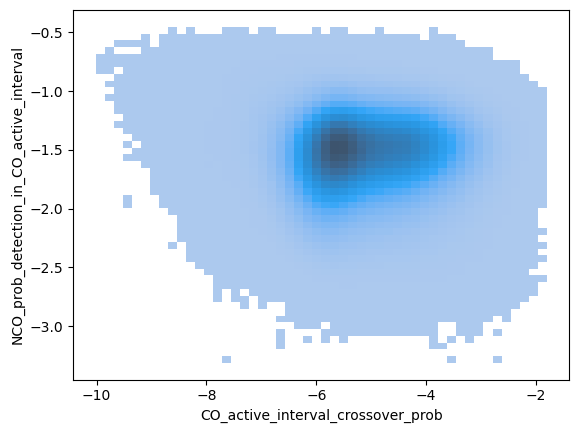

In [10]:
sns.histplot(
    (dense_reads_df
        .select(
            pl.col("CO_active_interval_crossover_prob").log10(), 
            pl.col("NCO_prob_detection_in_CO_active_interval").log10(),
        )
    ),
    x="CO_active_interval_crossover_prob",
    y="NCO_prob_detection_in_CO_active_interval",
    bins=50, 
)

In [11]:
scipy.stats.pearsonr(*(dense_reads_df
        .select(
            pl.col("CO_active_interval_crossover_prob").log10(), 
            pl.col("NCO_prob_detection_in_CO_active_interval").log10(),
        )
    ).to_numpy().T
)

PearsonRResult(statistic=0.027719192373235762, pvalue=0.0)

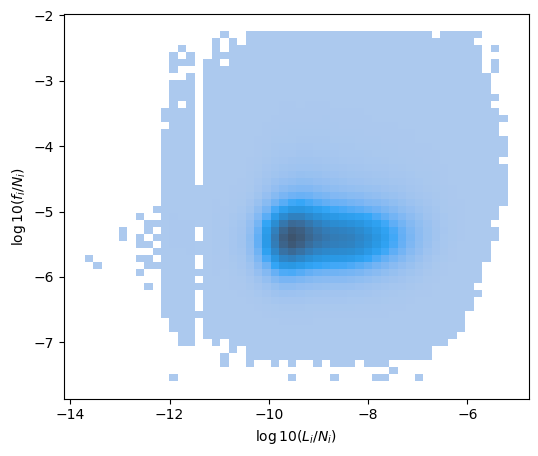

In [12]:
fig, ax = plt.subplots(figsize=(6,5))

sns.histplot(
    (dense_reads_df
        .select(
            (pl.col("CO_active_interval_crossover_prob") / pl.col("CO_active_interval_length_bp")).log10().alias("CO_active_interval_cM_rate"), 
            (pl.col("NCO_prob_detection_in_CO_active_interval") / pl.col("CO_active_interval_length_bp")).log10().alias("NCO_prob_detection_rate"),
        )
    ),
    x="CO_active_interval_cM_rate",
    y="NCO_prob_detection_rate",
    bins=50, 
    ax=ax,
)

ax.set_xlabel("$\log10(L_i/N_i)$");
ax.set_ylabel("$\log10(f_i/N_i)$");

In [13]:
scipy.stats.pearsonr(*(dense_reads_df
    .select(
        (pl.col("CO_active_interval_crossover_prob") / pl.col("CO_active_interval_start_length_bp")).log10().alias("CO_active_interval_cM_rate"), 
        (pl.col("NCO_prob_detection_in_CO_active_interval") / pl.col("CO_active_interval_start_length_bp")).log10().alias("NCO_prob_detection_rate"),
    )
    ).to_numpy().T
)

ColumnNotFoundError: CO_active_interval_start_length_bp

In [ ]:
df = (dense_reads_df
    .select(
        (pl.col("CO_active_interval_crossover_prob") / pl.col("CO_active_interval_start_length_bp")).log10().alias("CO_active_interval_cM_rate"), 
        (pl.col("NCO_prob_detection_in_CO_active_interval") / pl.col("CO_active_interval_start_length_bp")).log10().alias("NCO_prob_detection_rate"),
    )
)

scipy.stats.linregress(y=df["NCO_prob_detection_rate"], x=df["CO_active_interval_cM_rate"])

In [ ]:
10**0.019774522396442333

In [ ]:
df = (dense_reads_df
    .select(
        (pl.col("CO_active_interval_crossover_prob") / pl.col("CO_active_interval_start_length_bp")).log10().alias("CO_active_interval_cM_rate"), 
        pl.col("high_quality_snp_positions").list.len().alias("n_snps"),
    )
)

scipy.stats.linregress(y=df["n_snps"], x=df["CO_active_interval_cM_rate"])

# Cross with recombinant reads

In [ ]:
cls_df = pl.concat([
    pl.read_parquet(
        str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds")
            / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.classified_reads.parquet")
    ) \
    for focal_sample_id in sample_ids
    for chrom in aut_chrom_names
])

basic_filtering = \
    (~pl.col("has_common_transition")) & \
    (pl.col("min_coverage_between_transitions_hap1") >= 3) & \
    (pl.col("min_coverage_between_transitions_hap2") >= 3) & \
    (pl.col("mapq1") >= 60) & \
    (pl.col("mapq2") >= 60) & \
    (pl.col("is_forward1") == pl.col("is_forward2"))

extra_filtering = \
    (pl.col("total_mismatches") <= 100) & \
    (pl.col("total_clipping") <= 10)

very_trusty_cls_df = cls_df.filter(basic_filtering & extra_filtering)


### Re-call the class only on high quality SNPs, only in the active region, but use the filtering of reads to avoid problems like fake COs from low coverage etc.

In [ ]:
dense_reads_with_detection_df = (dense_reads_df
    .join(
        very_trusty_cls_df.select("read_name", "class"),
        on="read_name",
        how="left",
    )                  
)

dense_reads_with_detection_df = (dense_reads_df    
    .join(
        (dense_reads_with_detection_df
            .with_columns(
                high_quality_snps_diff = pl.col("high_quality_snp_positions_alleles").list.diff(null_behavior="drop"),
            )
            .with_columns(
                high_quality_snps_transitions = pl.col("high_quality_snps_diff").list.eval(pl.element() != 0).cast(pl.List(int)),        
            )
            .with_columns(
                high_quality_detected_class = pl.when( 
                    (pl.col("class").is_not_null()) &
                    (pl.col("high_quality_snp_positions_alleles").list.get(0) == pl.col("high_quality_snp_positions_alleles").list.get(1)) &
                    (pl.col("high_quality_snp_positions_alleles").list.get(-1) == pl.col("high_quality_snp_positions_alleles").list.get(-2))
                ).then(
                    pl.when(
                        pl.col("high_quality_snps_transitions").list.sum() == 1
                    ).then(
                        pl.lit("CO")
                    ).when(
                        pl.col("high_quality_snps_transitions").list.sum() == 2
                    ).then(
                        pl.lit("NCO")
                    )
                )
            )
            .select("read_name", "high_quality_detected_class")
        ),
        on="read_name",
    )        
)                                 

# Test 1: Assume independence between active interval genetic lengths and detected event

## Test across all data

In [ ]:
df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_detected_class").is_not_null())
    .select(
        "CO_active_interval_crossover_prob",
        "high_quality_detected_class",
    )
)
 
CO_lens = df.filter(pl.col("high_quality_detected_class") == "CO")["CO_active_interval_crossover_prob"] * 1e2
NCO_lens = df.filter(pl.col("high_quality_detected_class") == "NCO")["CO_active_interval_crossover_prob"] * 1e2
all_lens = (dense_reads_with_detection_df
    .filter(pl.col("CO_active_interval_crossover_prob") > 0)
    .sample(fraction=1e-3)
    ["CO_active_interval_crossover_prob"] * 1e2
)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

sns.histplot(
    [
        pd.Series(CO_lens, name="CO"),
        pd.Series(NCO_lens, name="NCO"),
        pd.Series(all_lens, name="All reads"),
    ], 
    bins=25, #np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Active interval genetic length (cM)");


In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

sns.histplot(
    [
        pd.Series(np.log10(CO_lens), name="CO"),
        pd.Series(np.log10(NCO_lens), name="NCO"),
        pd.Series(np.log10(all_lens), name="All reads"),
    ], 
    bins=25, #np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Active interval genetic length, log10(cM)");


In [ ]:
df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_detected_class").is_not_null())
    .select(
        "CO_active_interval_crossover_prob",
        "high_quality_detected_class",
        "CO_active_interval_start_length_bp",
    )
)
 
CO_rates = (
    df.filter(pl.col("high_quality_detected_class") == "CO")["CO_active_interval_crossover_prob"] * 1e2 /
    (df.filter(pl.col("high_quality_detected_class") == "CO")["CO_active_interval_start_length_bp"] * 1e-6)
)
NCO_rates = (
    df.filter(pl.col("high_quality_detected_class") == "NCO")["CO_active_interval_crossover_prob"] * 1e2 /
    (df.filter(pl.col("high_quality_detected_class") == "NCO")["CO_active_interval_start_length_bp"] * 1e-6)
)
sdf = (dense_reads_with_detection_df
    .filter(pl.col("CO_active_interval_crossover_prob") > 0)
    .sample(fraction=1e-1)
)
all_rates = (
    sdf["CO_active_interval_crossover_prob"] * 1e2 / 
    (sdf["CO_active_interval_start_length_bp"] * 1e-6)
)

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))

sns.histplot(
    [
        pd.Series(np.log10(CO_rates), name="CO"),
        pd.Series(np.log10(NCO_rates), name="NCO"),
        pd.Series(np.log10(all_rates), name="All reads"),
    ], 
    bins=np.linspace(-3, 2.5, 20),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
    ax=ax,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
#ax.set_xlim(-3,3);
ax.set_xlabel("Active interval recombination map rates, $log_{10}$(cM/Mb)");


In [ ]:
CO_rates

## Different chromosomes and samples?

In [ ]:
def test_condition(condition):
    df = (dense_reads_with_detection_df
        .filter(condition)
        .filter(pl.col("high_quality_detected_class").is_not_null())
        .select(
            "CO_active_interval_crossover_prob",
            "high_quality_detected_class",
        )
    )

    CO_lens = df.filter(pl.col("high_quality_detected_class") == "CO")["CO_active_interval_crossover_prob"] * 1e2
    NCO_lens = df.filter(pl.col("high_quality_detected_class") == "NCO")["CO_active_interval_crossover_prob"] * 1e2
    
    return len(CO_lens), len(NCO_lens), scipy.stats.ks_2samp(CO_lens, NCO_lens).pvalue, inference.permutation_testing([[CO_lens, NCO_lens]], 1000)

In [ ]:
rows = []
for chrom in tqdm.tqdm(aut_chrom_names):
    rows.append([chrom] + list(test_condition(pl.col("chrom") == chrom)))
    
with pl.Config(tbl_rows=100) as cfg:
    display(pl.DataFrame(rows, schema=["chrom", "n_events_CO", "n_events_NCO", "KS_pvalue", "AD_perm_pvalue"]))

In [ ]:
rows = []
for sample_id in tqdm.tqdm(sorted(sample_ids)):
    rows.append([sample_id] + list(test_condition(pl.col("sample_id") == sample_id)))
    
with pl.Config(tbl_rows=100) as cfg:
    display(pl.DataFrame(rows, schema=["sample_id", "n_events_CO", "n_events_NCO", "KS_pvalue", "AD_perm_pvalue"]))    

In [ ]:
df = (dense_reads_with_detection_df
    #.filter(pl.col("sample_id") == "PD50519d")
    .filter(pl.col("chrom") == "chr2")
    .filter(pl.col("high_quality_detected_class").is_not_null())
    .select(
        "CO_active_interval_crossover_prob",
        "high_quality_detected_class",
    )
)

CO_lens = df.filter(pl.col("high_quality_detected_class") == "CO")["CO_active_interval_crossover_prob"] * 1e2
NCO_lens = df.filter(pl.col("high_quality_detected_class") == "NCO")["CO_active_interval_crossover_prob"] * 1e2
   
sns.histplot(
    [
        pd.Series(np.log10(CO_lens), name="CO"),
        pd.Series(np.log10(NCO_lens), name="NCO"),
    ], 
    bins=25, #np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Active interval genetic length, log10(cM)");


### Different NCO distributions per sample?

In [ ]:
def test_two_samples_NCO(sample_id1, sample_id2, event_class):
    df = (dense_reads_with_detection_df
        .filter(pl.col("high_quality_detected_class") == event_class)
        .select(
            "sample_id",
            "CO_active_interval_crossover_prob",
            "high_quality_detected_class",
        )
    )

    lens_1 = df.filter(pl.col("sample_id") == sample_id1)["CO_active_interval_crossover_prob"] * 1e2
    lens_2 = df.filter(pl.col("sample_id") == sample_id2)["CO_active_interval_crossover_prob"] * 1e2
    
    return (
        len(lens_1), 
        len(lens_2), 
        scipy.stats.ks_2samp(lens_1, lens_2).pvalue, 
        inference.permutation_testing([[lens_1, lens_2]], 1000),
    )

In [ ]:
rows = []

for sample_id1, sample_id2 in itertools.combinations(sorted(sample_ids), 2):
    for event_class in ["CO", "NCO"]:
        rows.append([sample_id1, sample_id2, event_class] + list(test_two_samples_NCO(sample_id1, sample_id2, event_class)))
    
pairwise_nco_df = pl.DataFrame(
    rows,
    schema=["sample_id1", "sample_id2", "class", "n1", "n2", "ks_pvalue", "AD_perm_pvalue"],
)

In [ ]:
with pl.Config(tbl_rows=100) as cfg:
    display(pairwise_nco_df.sort("AD_perm_pvalue"))

### Test one sample vs. all others, in NCO distributions

In [ ]:
def test_sample_vs_rest_NCO(sample_id, event_class):
    df = (dense_reads_with_detection_df
        .filter(pl.col("high_quality_detected_class") == event_class)
        .select(
            "sample_id",
            "CO_active_interval_crossover_prob",
            "high_quality_detected_class",
        )
    )

    lens1 = df.filter(pl.col("sample_id") == sample_id)["CO_active_interval_crossover_prob"] * 1e2
    lens2 = df.filter(pl.col("sample_id") != sample_id)["CO_active_interval_crossover_prob"] * 1e2
    
    return (
        len(lens1), 
        len(lens2), 
        scipy.stats.ks_2samp(lens1, lens2).pvalue, 
        inference.permutation_testing([[lens1, lens2]], 1000),
    )

In [ ]:
rows = []

for sample_id in sorted(sample_ids):
    for event_class in ["CO", "NCO"]:
        rows.append([sample_id, event_class] + list(test_sample_vs_rest_NCO(sample_id, event_class)))
    
sample_vs_rest_nco_df = pl.DataFrame(
    rows,
    schema=["sample_id", "class", "n1", "n2", "ks_pvalue", "AD_perm_pvalue"],
)

In [ ]:
sample_vs_rest_nco_df.sort("AD_perm_pvalue")

In [ ]:
df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_detected_class") == "CO")
    .filter(pl.col("sample_id") != "PD50523b")
    .select(
        "sample_id",
        "CO_active_interval_crossover_prob",
        "high_quality_detected_class",
    )
)

x_lens = df.filter(pl.col("sample_id") == "PD50508f")["CO_active_interval_crossover_prob"] * 1e2
y_lens = df.filter(pl.col("sample_id") != "PD50508f")["CO_active_interval_crossover_prob"] * 1e2
   
sns.histplot(
    [
        pd.Series(np.log10(x_lens), name="PD50508f"),
        pd.Series(np.log10(y_lens), name="rest"),
    ], 
    bins=25, #np.linspace(0, 2, 25),
    multiple="dodge",
    shrink=0.8,
    stat="proportion",
    common_norm=False,
)

#plt.yscale("log");
#plt.ylim(0,0.05);
plt.xlabel("Active interval genetic length, log10(cM)");


# Test 2: Condition on number of SNPs

In [ ]:
cnt_df = (dense_reads_with_detection_df
    .filter(pl.col("high_quality_detected_class").is_not_null())
    .select(pl.col("high_quality_snp_positions").list.len().alias("n_snps"))
)

plt.hist(cnt_df["n_snps"], bins=np.arange(5,60));

### Per # of SNPs

In [ ]:
rows = []
for n_snps in tqdm.tqdm(np.arange(5, 30)):
    rows.append([n_snps] + list(test_condition(pl.col("high_quality_snp_positions").list.len() == n_snps)))
    
n_snps_df = pl.DataFrame(rows, schema=["n_snps", "n_events_CO", "n_events_NCO", "KS_pvalue", "AD_perm_pvalue"])    
with pl.Config(tbl_rows=100) as cfg:
    display(n_snps_df)



### Aggregate across all # of SNPs

In [ ]:
def test_condition_across_n_snps(condition, snp_groups, n_perms):
    df = (dense_reads_with_detection_df
        .filter(condition)
        .with_columns(
            n_snps = pl.col("high_quality_snp_positions").list.len(),
        )
        .filter(pl.col("n_snps") < 30)
        .filter(pl.col("high_quality_detected_class").is_not_null())
        .select(
            "n_snps",
            "CO_active_interval_crossover_prob",
            "high_quality_detected_class",
        )
    )

    pairs = [
        [
            df.filter((pl.col("n_snps").is_in(group)) & (pl.col("high_quality_detected_class") == "CO"))["CO_active_interval_crossover_prob"] * 1e2,
            df.filter((pl.col("n_snps").is_in(group)) & (pl.col("high_quality_detected_class") == "NCO"))["CO_active_interval_crossover_prob"] * 1e2,
        ] \
        for group in snp_groups]

    return inference.permutation_testing(pairs, n_perms=n_perms)


In [ ]:
test_condition_across_n_snps(pl.lit(True), , 1000)

### Per chrom

In [ ]:
def runme(chrom, group_size):
    snp_groups = np.array_split(np.arange(5, 30), (30-5)/group_size)
    pval = test_condition_across_n_snps(pl.col("chrom") == chrom, snp_groups, 10000)
    return [chrom, group_size, pval]

rows = joblib.Parallel(n_jobs=-1, verbose)(
    joblib.delayed(runme)(chrom, group_size)
    for chrom in aut_chrom_names
    for group_size in np.arange(1, 6)
)

chrom_snps_agg_df =     
with pl.Config(tbl_rows=100) as cfg:
    display()

### Per sample

In [ ]:
rows = []
for sample_id in tqdm.tqdm(sorted(sample_ids)):
    rows.append([sample_id, test_condition_across_n_snps(pl.col("sample_id") == sample_id, 10000)])
    
with pl.Config(tbl_rows=100) as cfg:
    display(pl.DataFrame(rows, schema=["sample_id", "AD_perm_pvalue"]))